In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
import geopandas as gpd
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction import text





file_path=r"C:\Users\Chen\Untitled Folder 1\whisky_data.csv"
file_path_copy=r"C:\Users\Chen\Untitled Folder 1\whisky_data_copy.csv"

In [83]:

df = pd.read_csv(r"C:\Users\Chen\Untitled Folder 1\whisky_data.csv", encoding='latin1')
df.to_csv(r"C:\Users\Chen\Untitled Folder 1\whisky_data_copy.csv", index=False)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5640 entries, 0 to 5639
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                5630 non-null   object 
 1   Distillery/Brand    5630 non-null   object 
 2   Region              5630 non-null   object 
 3   Bottler             5630 non-null   object 
 4   Country             5630 non-null   object 
 5   Rating              2327 non-null   float64
 6   Reviews             2327 non-null   object 
 7   Alcohol Percentage  5630 non-null   object 
 8   Price               4766 non-null   float64
 9   Awards              5640 non-null   int64  
 10  Palate              4127 non-null   object 
 11  Finish              4127 non-null   object 
 12  Nose                4127 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 572.9+ KB


In [84]:

df_copy = pd.read_csv("whisky_data_copy.csv", encoding='utf-8')
df_copy.drop_duplicates(subset=['Name'], inplace=True)
df_copy.to_csv("whisky_data_copy.csv", index=False)
df_copy.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5520 entries, 0 to 5639
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                5519 non-null   object 
 1   Distillery/Brand    5519 non-null   object 
 2   Region              5519 non-null   object 
 3   Bottler             5519 non-null   object 
 4   Country             5519 non-null   object 
 5   Rating              2244 non-null   float64
 6   Reviews             2244 non-null   object 
 7   Alcohol Percentage  5519 non-null   object 
 8   Price               4671 non-null   float64
 9   Awards              5520 non-null   int64  
 10  Palate              4039 non-null   object 
 11  Finish              4039 non-null   object 
 12  Nose                4039 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 603.8+ KB


In [85]:
def extract_reviews_from_csv(file_path_copy):
    df_copy = pd.read_csv(file_path_copy)
    df_copy['Reviews'] = df_copy['Reviews'].astype(str).str.extract('(\d+)').astype(float)
    df_copy.to_csv(file_path_copy, index=False)


In [42]:
def extract_original_price(df_copy):
    for index, row in df_copy.iterrows():
        price_string = str(row['Price'])
        price = float(re.sub(r'[^\d.]', '', price_string))
        
        if 21000 < price < 100000:
            price /= 1000
        elif price > 100000:
            price /= 10000
        
        df_copy.at[index, 'Price'] = round(price, 2)  

    df_copy.to_csv(file_path_copy, index=False)


In [43]:
def replace_empty_values(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    df_copy['Price'] = pd.to_numeric(df_copy['Price'], errors='coerce')  # Convert 'Price' to numeric

    #df_copy = df_copy.dropna(subset=['Name'])

    df_copy['Price'].fillna(df_copy['Price'].median(), inplace=True)
    df_copy.fillna({'Name': 'NaN',
                    'Distillery/Brand': 'NaN',
                    'Region': 'NaN',
                    'Bottler': 'NaN',
                    'Country': 'NaN',
                    'Rating': 0,
                    'Reviews': 0,
                    'Awards': 0,
                    'Capacity (cl)': 0,
                    'Alcohol Percentage': 0}, inplace=True)
    df_copy['Region'] = df_copy['Region'].str.replace(' Whisky', '')
    
    # Save the updated DataFrame back to the same file
    df_copy.to_csv(file_path_copy, index=False)
    
    prefixes = {
    'Nose:': 'Nose',
    'Palate:': 'Palate',
    'Finish:': 'Finish'
    }
    

    columns_to_process = ['Palate', 'Finish', 'Nose']

    for column in columns_to_process:
        df_copy[column] = df_copy[column].apply(lambda cell: re.search(f'{column}: (.+)', cell).group(1).strip() if pd.notnull(cell) and re.search(f'{column}: (.+)', cell) else cell)
        df_copy[column] = df_copy[column].apply(lambda cell: cell if cell in prefixes else f'{column}: {cell}')
    
    
    for column in columns_to_process:
        df_copy[column] = df_copy[column].str.replace(column + ':', '').str.strip()
        
    df_copy.to_csv(file_path_copy, index=False, na_rep='NaN')
    



In [44]:
def Remove_Nan_in_PNF(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    columns_to_process = ['Palate', 'Finish', 'Nose']
    df_copy=df_copy.dropna(subset=columns_to_process,how='all')
    df_copy.to_csv(file_path_copy, index=False, na_rep='NaN')


In [45]:
def split_alcohol_percentage(file_path_copy):
    df_copy = pd.read_csv(file_path_copy, encoding='utf-8')
    df_copy['Alcohol Percentage'] = df_copy['Alcohol Percentage'].astype(str)
    
    df_copy[['Capacity (cl)', 'Alcohol Percentage %']] = df_copy['Alcohol Percentage'].str.split(',', expand=True)
    df_copy['Capacity (cl)'] = df_copy['Capacity (cl)'].str.extract('(\d+)')
    df_copy['Alcohol Percentage %'] = df_copy['Alcohol Percentage %'].str.extract('(\d+)')
    
    #df['Has_Age'] = df['Name'].apply(lambda x: 1 if 'Age' in x else 0)

    
    column_order = ['Name', 'Distillery/Brand', 'Region', 'Bottler', 'Country', 'Rating', 'Reviews',
                'Capacity (cl)', 'Alcohol Percentage %', 'Price', 'Awards', 'Palate', 
                'Finish', 'Nose', 'Alcohol Percentage']
    df_copy = df_copy[column_order]
    
    df_copy.to_csv(file_path_copy,index=False,na_rep='NaN')
    


In [79]:
def find_outliers_IQR(df_copy):

    q1=df_copy.quantile(0.25)

    q3=df_copy.quantile(0.75)

    IQR=q3-q1

    outliers = df_copy[((df_copy<(q1-1.5*IQR)) | (df_copy>(q3+1.5*IQR)))]

    return outliers

In [80]:
outliers = find_outliers_IQR(df_copy['Awards'])

print('number of outliers:' + str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

z_score = (df_copy["Awards"] - df_copy["Awards"].mean()) / df_copy["Awards"].std()
outliers = abs(z_score)> 5.8
print(sum(outliers))
df_copy.info()
df_copy.loc[abs(z_score) > 5.8,'Awards']=np.nan
df_copy.dropna(subset=['Awards'], inplace=True)
df_copy.to_csv(file_path_copy, index=False)
df_copy.info()


number of outliers:617
max outlier value: 7.0
min outlier value: 1.0
16
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3973 entries, 0 to 4002
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  3973 non-null   object 
 1   Distillery/Brand      3973 non-null   object 
 2   Region                3973 non-null   object 
 3   Bottler               3973 non-null   object 
 4   Country               3973 non-null   object 
 5   Rating                3973 non-null   float64
 6   Reviews               3973 non-null   float64
 7   Capacity (cl)         3973 non-null   int64  
 8   Alcohol Percentage %  3973 non-null   int64  
 9   Price                 3973 non-null   float64
 10  Awards                3973 non-null   float64
 11  Palate                3973 non-null   object 
 12  Finish                3973 non-null   object 
 13  Nose                  3973 non-null   object 
 14  

<AxesSubplot:>

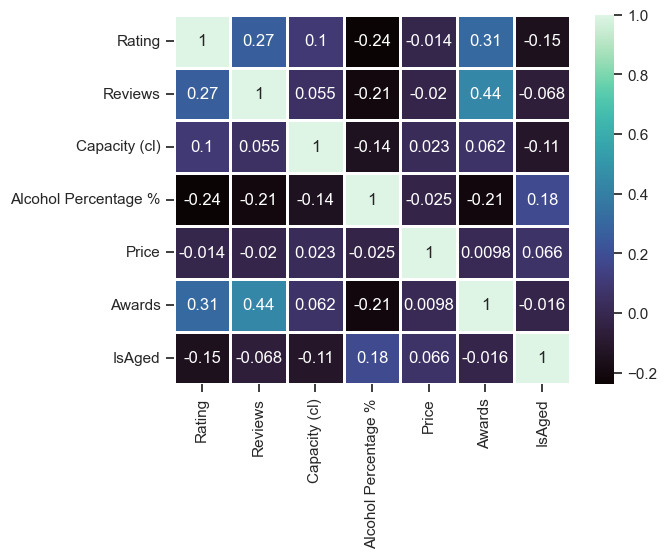

In [81]:
sns.heatmap(df_copy.corr(), annot=True,cmap="mako",linewidths=1)


In [49]:
def plot_awards_vs_numerical_columns(df_copy):
    numerical_cols = ['Rating', 'Reviews', 'Capacity (cl)', 'Alcohol Percentage %', 'Price']

    fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(10, 15))

    # Set a custom color palette
    colors = sns.color_palette("Set2")

    for i, col in enumerate(numerical_cols):
        ax[i].scatter(df_copy['Awards'], df_copy[col], color=colors[i % len(colors)])
        ax[i].set_title('Awards vs ' + col, fontweight='bold')
        ax[i].set_xlabel('Awards')
        ax[i].set_ylabel(col)

    plt.tight_layout()
    plt.show()

sns.set(style='ticks')


In [50]:
def show_whiskey_awards(df_copy):
    # Categorical columns for analysis
    categorical_columns = ['Region', 'Country']

    for column in categorical_columns:
        unique_categories = df_copy[column].nunique()
        figsize = ( unique_categories * 0.5, 10)
        plt.figure(figsize=figsize)
        ax = df_copy.groupby(column)['Awards'].value_counts().unstack().plot(kind='bar', stacked=True)
        plt.xlabel(column, fontsize=16)
        plt.ylabel('Count', fontsize=16)
        plt.title(f'Awards Distribution by {column}', fontsize=18)
        plt.xticks(rotation=90, fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(title='Awards', fontsize=12, bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.show()



In [51]:
def update_region_names(df_copy):
    country_mapping = {
        'Scotch': 'Scotland',
        'Islay': 'Scotland',
        'Speyside': 'Scotland',
        'Island': 'Scotland',
        'Highland': 'Scotland',
        'Campbeltown': 'Scotland',
        'Lowland': 'Scotland',
        'Finnish': 'Finland',
        'Japanese': 'Japan',
        'Irish Whiskey': 'Ireland',
        'Welsh': 'Wales',
        'Indian': 'India',
        'American Whiskey': 'United States',
        'English': 'England',
        'Canadian': 'Canada',
        'Other Scotch': 'Scotland',
        'Swedish': 'Sweden',
        'South African': 'South Africa',
        'Dutch Whiskies': 'Netherlands',
        'Taiwanese': 'Taiwan',
        'Israeli Whiskies': 'Israel',
        'Italian': 'Italy',
        'Kiwi': 'New Zealand',
        'Danish': 'Denmark'
    }
    
    df_copy['Region'] = df_copy['Region'].map(country_mapping).fillna(df_copy['Region'])
    df_copy.to_csv(file_path_copy, index=False)



In [52]:

def create_reviews_scatter_plot(df_copy):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the prices
    ax.plot(df_copy['Reviews'])

    # Set the labels and title
    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Reviews Variation')

    # Show the plot
    plt.show()



In [53]:
def update_aged_column(df_copy):
    def is_whisky_aged(name):
        if 'old' in name.lower():
            return 1
        else:
            return 0
    
    df_copy['IsAged'] = df_copy['Name'].apply(is_whisky_aged)
    df_copy.to_csv(file_path_copy, index=False)
    
    aged_whiskies = df_copy[df_copy['IsAged'] == 1]
    non_aged_whiskies = df_copy[df_copy['IsAged'] == 0]
    
    aged_whiskies_with_awards = aged_whiskies[aged_whiskies['Awards'] > 0]
    non_aged_whiskies_with_awards = non_aged_whiskies[non_aged_whiskies['Awards'] > 0]
    
    aged_whiskies_without_awards = aged_whiskies[aged_whiskies['Awards'] == 0]
    non_aged_whiskies_without_awards = non_aged_whiskies[non_aged_whiskies['Awards'] == 0]
    
    awards_counts = [
        len(aged_whiskies_with_awards),
        len(non_aged_whiskies_with_awards)
    ]
    
    no_awards_counts = [
        len(aged_whiskies_without_awards),
        len(non_aged_whiskies_without_awards)
    ]
    
    labels = ['Aged Whiskies', 'Non-Aged Whiskies']
    
    colors = ['#FFD700', '#00BFFF']  
    
    plt.bar(labels, awards_counts, color=colors)
    plt.xlabel('Whisky Type')
    plt.ylabel('Number of Whiskies with Awards')
    plt.title('Number of Whiskies with Awards for Aged and Non-Aged Whiskies')
    
    for i, count in enumerate(awards_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.show()
    
    plt.bar(labels, no_awards_counts, color=colors)
    plt.xlabel('Whisky Type')
    plt.ylabel('Number of Whiskies without Awards')
    plt.title('Number of Whiskies without Awards for Aged and Non-Aged Whiskies')
    
    # Add labels to the bars
    for i, count in enumerate(no_awards_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')
    
    # Apply styling
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    
    plt.show()

In [54]:
def create_price_scatter_plot(df_copy):
    df_copy_2 = df_copy.reset_index()

    fig, ax = plt.subplots()

    regions = df_copy_2['Region'].unique()
    colors = plt.cm.tab20(np.linspace(0, 1, len(regions)))  # Generate a color palette

    for region, color in zip(regions, colors):
        region_data = df_copy_2[df_copy_2['Region'] == region]
        ax.scatter(region_data.index, region_data['Price'], label=region, color=color, alpha=0.7)

    ax.set_xlabel('Index')
    ax.set_ylabel('Price')
    ax.set_title('Price Variation by Region')

    num_ticks = 10  # Number of ticks to display
    step = len(df_copy_2.index) // num_ticks
    indices = df_copy_2.index[::step]  
    ax.set_xticks(indices)

    ax.set_ylim(50, 5000)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.grid(axis='both', linestyle='--', alpha=0.5)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [130]:
def plot_heatmap_by_region(dataframe, region_column):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    merged = world.merge(dataframe, left_on='name', right_on=region_column)

    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot all other countries in grey
    world[~world['name'].isin(merged[region_column])].plot(ax=ax, color='lightgrey')
    
    # Plot the merged countries with the specified column
    merged.plot(column=region_column, cmap='hot', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

    ax.set_title(f'Heatmap by {region_column}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.show()


C:\Users\Chen\AppData\Local\Temp\ipykernel_24160\3922742297.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


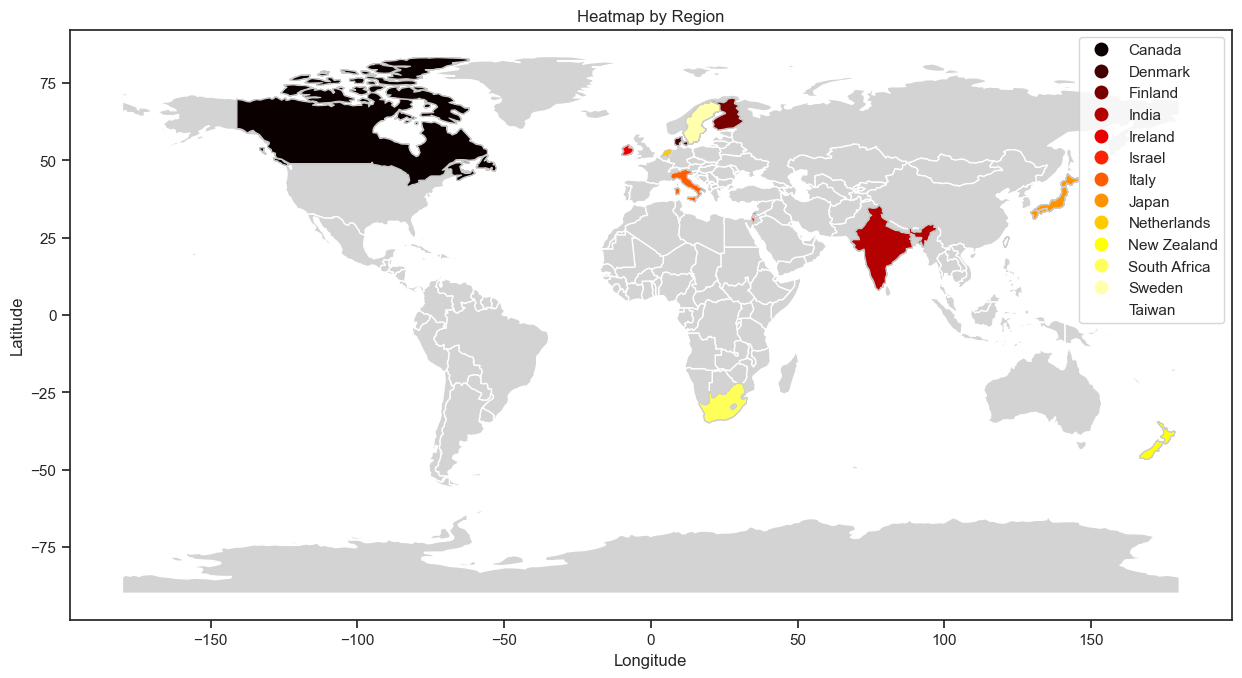

In [133]:
extract_reviews_from_csv(file_path_copy)
#df_copy = pd.read_csv(file_path_copy)
replace_empty_values(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
extract_original_price(df_copy)
df_copy = pd.read_csv(file_path_copy)
Remove_Nan_in_PNF(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
split_alcohol_percentage(file_path_copy)
df_copy = pd.read_csv(file_path_copy)
update_region_names(df_copy)
df_copy = pd.read_csv(file_path_copy)
#show_whiskey_awards(df_copy)
df_copy = pd.read_csv(file_path_copy)
numerical_columns = ['Rating', 'Awards']
#show_numerical_eda(df_copy, numerical_columns)
#create_reviews_scatter_plot(df_copy)
df_copy = pd.read_csv(file_path_copy)
#create_price_scatter_plot(df_copy)
df_copy = pd.read_csv(file_path_copy)
#update_aged_column(df_copy)
df_copy = pd.read_csv(file_path_copy)
#Rating_dist_by_region(df_copy)
df_copy = pd.read_csv(file_path_copy)
#create_classification_models(df_copy)
df_copy = pd.read_csv(file_path_copy)
plot_heatmap_by_region(df_copy, 'Region')





## 

In [57]:
#pd.crosstab(df_copy["Awards"], df_copy["Rating"],normalize='index')
#df_copy.info()
# Box plot of 'Rating' grouped by 'Region'
def show_numerical_eda(df_copy, numerical_columns):
    for column in numerical_columns:
        unique_values = df_copy[column].unique()
        plt.figure(figsize=(10, 6))
        plt.hist(df_copy[column], bins=10)
        plt.xlabel(column, fontsize=16)
        plt.ylabel('Frequency', fontsize=16)
        plt.title(f'Distribution of {column}', fontsize=18)
        plt.xticks(unique_values, fontsize=12, rotation=90)
        plt.tight_layout()
        plt.show()





In [86]:
def create_classification_models(df_copy):
    categorical_cols = ["Region", "Bottler", "Country"]

    # Initialize the LabelEncoder
    encoder = LabelEncoder()

    # Encode the categorical columns
    for col in categorical_cols:
        df_copy[col] = encoder.fit_transform(df_copy[col])

    # Define the features and target
    X = df_copy[['Rating', 'Reviews', 'Capacity (cl)', 'Alcohol Percentage %', 'Price']]
    y = df_copy['Awards']

    # Scaling numeric features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize and train the models
    models = [
        LogisticRegression(solver='liblinear', max_iter=5000),
        RandomForestClassifier(),
        GaussianNB()
    ]

    model_names = ['Logistic Regression', 'Random Forest', 'Naive Bayes']
    accuracy_scores = []

    for model, model_name in zip(models, model_names):
        # Perform cross-validation
        scores = cross_val_score(model, X_scaled, y, cv=5)

        # Calculate the average accuracy score
        accuracy = scores.mean()
        accuracy_scores.append(accuracy)

    # Plot the accuracy scores with custom labels and scores
    plt.bar(model_names, accuracy_scores)
    plt.xlabel('Model')
    plt.ylabel('Accuracy Score')
    plt.title('Accuracy Scores for Different Classification Models')

    for i, score in enumerate(accuracy_scores):
        plt.text(i, score, f'{score:.2f}', ha='center', va='bottom')

    # Set the y-axis limit to 1.0
    plt.ylim(0, 1.0)

    # Apply styling
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()

    plt.show()

In [59]:
def Rating_dist_by_region(df_copy):
    sns.boxplot(x='Region', y='Rating', data=df_copy)
    plt.xlabel('Region')
    plt.ylabel('Rating')
    plt.title('Rating Distribution by Region')

    plt.xticks(rotation=90)

    plt.show()

Text used for fitting:
Text used for prediction:
Accuracy: 0.7957920792079208


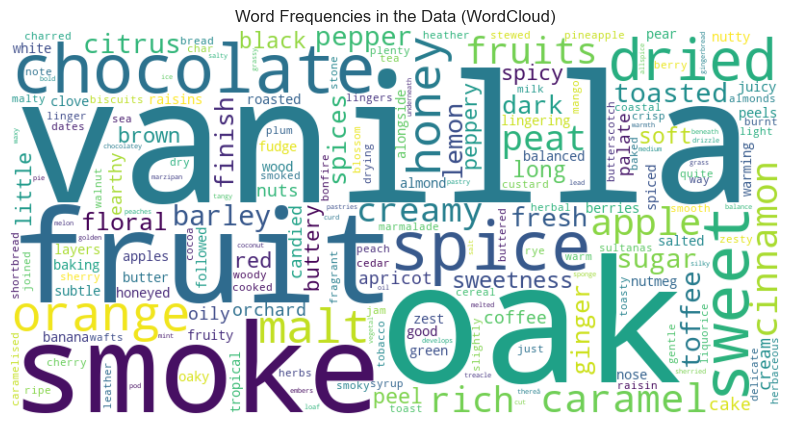

In [129]:
def create_simple_pipeline():
    extra_stop_words = set(['notes', 'touch', 'hint', 'hints'])
    stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)
    clf_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=stop_words)),
    ('classifier', MultinomialNB())
    ])
    return clf_pipeline

def fit(clf_pipeline, df_train):
    X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
    X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
    y_train = df_train['Awards']
    return clf_pipeline.fit(X_train, y_train)

def predict(clf_trained_pipeline, df_test):
    X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
    X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
    return clf_trained_pipeline.predict(X_test)

def evaluate_accuracy(y_test, y_predicted):
    return accuracy_score(y_test, y_predicted)

df_train, df_test = train_test_split(df_copy, test_size=0.2, random_state=42)

clf_pipeline = create_simple_pipeline()

X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
y_train = df_train['Awards']
clf_pipeline.fit(X_train, y_train)

X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
y_test = df_test['Awards']
y_predicted = clf_pipeline.predict(X_test)

accuracy = evaluate_accuracy(y_test, y_predicted)
print("Accuracy:", accuracy)

analyzed_text = clf_pipeline.named_steps['vectorizer'].transform(X_test)
feature_names = clf_pipeline.named_steps['vectorizer'].get_feature_names_out()

word_frequencies = np.asarray(analyzed_text.sum(axis=0)).squeeze()

sorted_indices = np.argsort(word_frequencies)[::-1]

top_n = 10
display_word_frequencies(df_train, df_test)

#print("Top", top_n, "most common words:")
#for i in range(top_n):
#    word_index = sorted_indices[i]
#    word_frequency = word_frequencies[word_index]
#    word = feature_names[word_index]
#    print(f"{word}: {word_frequency} occurrences")

In [122]:

def display_word_frequencies(df_train, df_test):
    clf_pipeline = create_simple_pipeline()

    X_train = df_train[['Nose', 'Palate', 'Finish']].astype(str)
    X_train = X_train.apply(lambda x: ' '.join(x.dropna()), axis=1)
    y_train = df_train['Awards']
    clf_pipeline.fit(X_train, y_train)
    
    X_test = df_test[['Nose', 'Palate', 'Finish']].astype(str)
    X_test = X_test.apply(lambda x: ' '.join(x.dropna()), axis=1)
    
    analyzed_text = clf_pipeline.named_steps['vectorizer'].transform(X_test)
    feature_names = clf_pipeline.named_steps['vectorizer'].get_feature_names_out()
    
    word_frequencies = np.asarray(analyzed_text.sum(axis=0)).squeeze()
    sorted_indices = np.argsort(word_frequencies)[::-1]
    
    # Filter out stop words
    stop_words = clf_pipeline.named_steps['vectorizer'].stop_words_
    filtered_indices = [i for i in sorted_indices if feature_names[i] not in stop_words]
    
    # Get all words and their frequencies
    words = [feature_names[i] for i in filtered_indices]
    frequencies = word_frequencies[filtered_indices]
    
    # Create a dictionary of word frequencies
    word_freq_dict = dict(zip(words, frequencies))
    
    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Frequencies in the Data (WordCloud)')
    plt.show()
